In [ ]:
# import needed library
import re
from collections import defaultdict
import getpass
import pandas as pd
import random
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import numpy as np
import os
import seaborn as sns

# import spark library
import pyspark
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [52]:
# Define some helper functions to make working with Spark easier
def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [54]:
start_spark(executor_instances=2, executor_cores=2, worker_memory=2, master_memory=2)

spark.dynamicAllocation.enabled,false
spark.executor.memory,2g
spark.sql.warehouse.dir,file:/users/home/ywa286/spark-warehouse
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.driver.port,42791
spark.executor.cores,2
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.app.name,ywa286 (jupyter)
spark.sql.shuffle.partitions,16
spark.cores.max,4


In [9]:
# Define type mapping for schema inference
type_mapping = {
    "string": StringType(),
    "real": FloatType(),
    "numeric": DoubleType(),
}

In [10]:
# Define a function to generate a schema from feature perfix
def generate_schema(dataset_prefix):
    attributes_dir = '/data/msd/audio/attributes/'
    
    schema_fields = []
    
    # Construct the full HDFS path
    attribute_file = f"{dataset_prefix}.attributes.csv"
    file_path = f"{attributes_dir}{attribute_file}"
    
    # Use Spark to read the file from HDFS
    try:
        attribute_rdd = spark.sparkContext.textFile(file_path)
        
        # Process each line in the RDD
        for line in attribute_rdd.collect():
            parts = line.strip().split(',')
            
            if len(parts) == 1:
                # If there's only one part, it might be just the attribute name
                name = parts[0]
                attr_type = "string"  # Default to string if type is not specified
            elif len(parts) >= 2:
                name = parts[0]
                attr_type = parts[1].lower()
            else:
                print(f"Warning: Unexpected line format: {line}")
                continue
            
            if attr_type in type_mapping:
                field = StructField(name, type_mapping[attr_type], True)
                schema_fields.append(field)
            else:
                print(f"Warning: Unknown type '{attr_type}' for attribute '{name}'. Using StringType.")
                field = StructField(name, StringType(), True)
                schema_fields.append(field)
        
        return StructType(schema_fields)
    
    except Exception as e:
        print(f"Error reading attribute file: {file_path}")
        print(f"Error details: {str(e)}")
        return None

## Q1 Audio Features Exploring

### (a)

In [11]:
# Loading one of the audio feature datasets
feature_path = "/data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv"
feature_perfix = os.path.splitext(os.path.basename(feature_path).strip())[0]
struct_type = generate_schema(feature_perfix)
example_feature_df = spark.read.csv(feature_path, header=False, schema=struct_type)
example_feature_df = example_feature_df.withColumn(
    "MSD_TRACKID", 
    F.regexp_replace(F.col("MSD_TRACKID"), "'", "")
)

In [13]:
# Define a function to rename columns and implement it
def rename_columns(df):
    # Create a list of (old_name, new_name) tuples
    column_mapping = [
        (c, c.replace("Method_of_Moments_Overall_Standard_Deviation", "MoM_O_Std")
           .replace("Method_of_Moments_Overall_Average", "MoM_O_Avg"))
        for c in df.columns
    ]
    
    # Apply the renaming
    for old_name, new_name in column_mapping:
        df = df.withColumnRenamed(old_name, new_name)
    
    return df

example_feature_df = rename_columns(example_feature_df)
show_as_html(example_feature_df)

,MoM_O_Std_1,MoM_O_Std_2,MoM_O_Std_3,MoM_O_Std_4,MoM_O_Std_5,MoM_O_Avg_1,MoM_O_Avg_2,MoM_O_Avg_3,MoM_O_Avg_4,MoM_O_Avg_5,MSD_TRACKID
0,0.15450,13.110000,840.000000,41080.0,7108000.0,0.3190,33.410000,1371.000000,64240.0,8398000.0,TRHFHQZ12903C9E2D5
1,0.11950,13.020000,611.900024,43880.0,7226000.0,0.2661,30.260000,1829.000000,183800.0,31230000.0,TRHFHYX12903CAF953
2,0.23260,7.185000,362.200012,19890.0,3030000.0,0.8854,32.680000,1384.000000,79190.0,9862000.0,TRHFHAU128F9341A0E
3,0.22830,10.300000,463.799988,24730.0,3336000.0,0.4321,37.560001,2047.000000,197200.0,32930000.0,TRHFHLP128F14947A7
4,0.18410,8.544000,359.399994,21900.0,3359000.0,0.8438,36.360001,2008.000000,205400.0,35390000.0,TRHFHFF128F930AC11
5,0.14600,8.248000,519.400024,42300.0,6138000.0,0.2782,19.080000,1052.000000,130900.0,22930000.0,TRHFHYJ128F4234782
6,0.09586,6.915000,409.899994,29840.0,4691000.0,0.2130,23.500000,1140.000000,81350.0,10120000.0,TRHFHHR128F9339010
7,0.08700,16.370001,560.400024,36280.0,4264000.0,0.1110,21.969999,845.799988,49790.0,6573000.0,TRHFHMB128F4213BC9
8,0.09981,7.871000,550.900024,46880.0,7261000.0,0.2457,14.070000,841.500000,104800.0,18470000.0,TRHFHWT128F429032D
9,0.23900,15.110000,729.200012,43200.0,6646000.0,0.4067,32.730000,2045.000000,175200.0,28720000.0,TRHFHKO12903CBAF09


In [ ]:
# Define the feature columns
feature_cols = ['MoM_O_Std_1', 
                'MoM_O_Std_2',
                'MoM_O_Std_3',
                'MoM_O_Std_4',
                'MoM_O_Std_5',
                'MoM_O_Avg_1',
                'MoM_O_Avg_2',
                'MoM_O_Avg_3',
                'MoM_O_Avg_4',
                'MoM_O_Avg_5',]

In [10]:
# Generate descriptive statistics for each audio feature or column in dataset
# Get list of numeric columns (excluding 'track_id')
numeric_columns = [c for c in example_feature_df.columns 
                   if c != "MSD_TRACKID" 
                   and example_feature_df.schema[c].dataType.typeName() in ['double', 'float', 'int', 'long']]

# Select numeric columns
numeric_df = example_feature_df.select(numeric_columns)

# Generate descriptive statistics
desc_stats = numeric_df.describe()

# Show the results
show_as_html(desc_stats)

,summary,MoM_O_Std_1,MoM_O_Std_2,MoM_O_Std_3,MoM_O_Std_4,MoM_O_Std_5,MoM_O_Avg_1,MoM_O_Avg_2,MoM_O_Avg_3,MoM_O_Avg_4,MoM_O_Avg_5
0,count,994623,994623,994623,994623,994623,994623,994623,994623,994623,994623
1,mean,0.15498176000543093,10.38455057775096,526.8139724161344,35071.97543290272,5297870.369577217,0.3508444432582955,27.463867987292343,1495.8091812092161,143165.4616325782,2.396783048473542E7
2,stddev,0.0664621308542395,3.8680013941281324,180.43775498537747,12806.816272955573,2089356.4364558058,0.18557956833459083,8.35264859376609,505.89376391905273,50494.276171032776,9307340.299219642
3,min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-146300.0,0.0
4,max,0.959,55.42,2919.0,407100.0,4.657E7,2.647,117.0,5834.0,452500.0,9.477E7


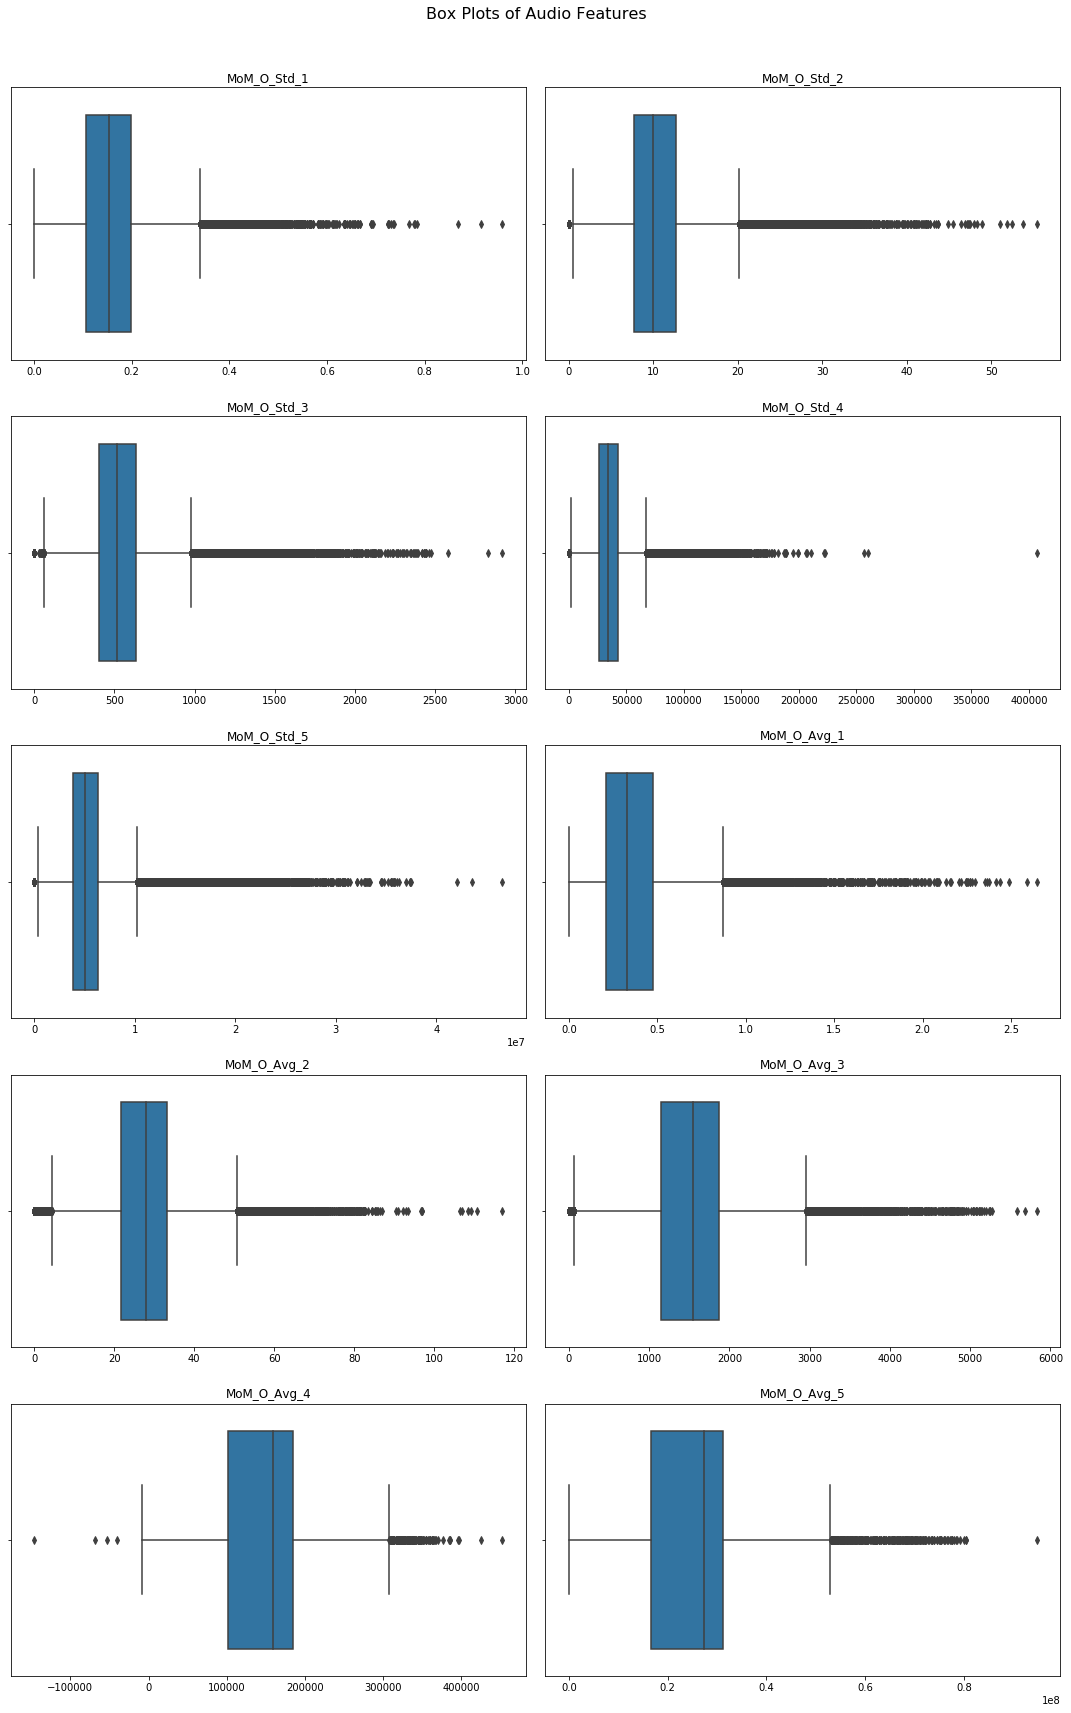

In [37]:
# Visualize the distribution of each audio feature
pandas_df = numeric_df.toPandas()

# Get the list of feature names
feature_names = numeric_df.columns

# Set up the plot
fig, axes = plt.subplots(nrows=(len(feature_names) + 1) // 2, ncols=2, figsize=(15, 5 * ((len(feature_names) + 1) // 2)))
fig.suptitle('Box Plots of Audio Features', fontsize=16)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Create a box plot for each feature
for i, feature in enumerate(feature_names):
    sns.boxplot(x=pandas_df[feature], ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('')

# Remove any unused subplots
for i in range(len(feature_names), len(axes)):
    fig.delaxes(axes[i])

# Adjust the layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

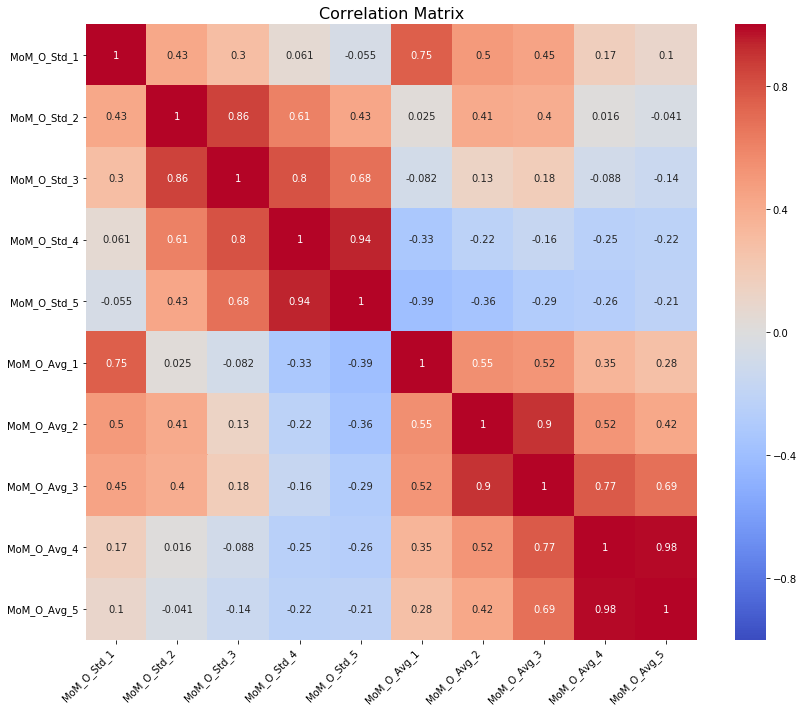

In [15]:
# get the correlation between these features
def get_correlation_matrix(df, columns):
    # Create a vector column of features
    vector_col = "features"
    assembler = VectorAssembler(inputCols=columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)

    # Compute correlation matrix
    matrix = Correlation.corr(df_vector, vector_col)
    
    # Convert to Pandas for easier handling
    corr_matrix = matrix.collect()[0][0].toArray().tolist()
    
    # Create a Pandas DataFrame with column names
    corr_df = pd.DataFrame(corr_matrix, columns=columns, index=columns)
    
    return corr_df

def plot_correlation_heatmap(correlation_matrix, title='Correlation Matrix'):
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))
    
    # Create a heatmap
    sns.heatmap(correlation_matrix, 
                annot=True,  # Annotate each cell with the numeric value
                cmap='coolwarm',  # Color map (red for positive, blue for negative correlations)
                vmin=-1, vmax=1,  # Fix the range of values to [-1, 1]
                center=0)  # Center the colormap at 0
    
    # Set the title
    plt.title(title, fontsize=16)
    
    # Rotate the tick labels
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Tight layout to ensure all labels are visible
    plt.tight_layout()
    
    # Show the plot
    plt.show()

correlation_matrix = get_correlation_matrix(example_feature_df, feature_cols)
plot_correlation_heatmap(correlation_matrix)

In [16]:
# Process the audio features dataset
def preprocess_audio_features(df: DataFrame, feature_cols: list) -> DataFrame:
    """
    Preprocess audio features for classification tasks, keeping scaled features as individual columns.
    
    Args:
    df (DataFrame): Input DataFrame containing audio features
    feature_cols (list): List of feature column names to preprocess
    
    Returns:
    DataFrame: Preprocessed DataFrame with features ready for classification
    """

    track_id_col = "MSD_TRACKID"
    
    # 1. Handle outliers using winsorization (capping at 1st and 99th percentiles)
    for col in feature_cols:
        percentiles = df.approxQuantile(col, [0.01, 0.99], 0.01)
        df = df.withColumn(
            f"{col}_winsorized",
            F.when(F.col(col) < percentiles[0], percentiles[0])
             .when(F.col(col) > percentiles[1], percentiles[1])
             .otherwise(F.col(col))
        )

    # 2. Log transformation for skewed features
    log_cols = [f"{col}_log" for col in feature_cols]
    for original_col, log_col in zip(feature_cols, log_cols):
        df = df.withColumn(log_col, F.log1p(F.abs(F.col(f"{original_col}_winsorized"))))

    # 3. Assemble features into a vector
    assembler = VectorAssembler(inputCols=log_cols, outputCol="features_vec")
    
    # 4. Standardize features
    scaler = StandardScaler(inputCol="features_vec", outputCol="features_scaled", withStd=True, withMean=True)
    
    # Create and fit the pipeline
    pipeline = Pipeline(stages=[assembler, scaler])
    model = pipeline.fit(df)
    
    # Transform the data
    df_processed = model.transform(df)
    
    # 5. Extract individual scaled features
    for i, col in enumerate(feature_cols):
        df_processed = df_processed.withColumn(col, vector_to_array("features_scaled")[i])

    # Select only the original columns (now containing scaled features) and the track_id_col
    final_df = df_processed.select(*feature_cols, track_id_col)
    
    return final_df

processed_df = preprocess_audio_features(example_feature_df, feature_cols)
show_as_html(processed_df)

In [17]:
# Generate descriptive statistics for each audio feature or column in processed dataset
# Get list of numeric columns (excluding 'track_id')
numeric_columns = [c for c in processed_df.columns 
                   if c != "MSD_TRACKID" 
                   and processed_df.schema[c].dataType.typeName() in ['double', 'float', 'int', 'long']]

# Select numeric columns
numeric_df = processed_df.select(numeric_columns)

# Generate descriptive statistics
desc_stats = numeric_df.describe()

# Show the results
show_as_html(desc_stats)

,summary,MoM_O_Std_1,MoM_O_Std_2,MoM_O_Std_3,MoM_O_Std_4,MoM_O_Std_5,MoM_O_Avg_1,MoM_O_Avg_2,MoM_O_Avg_3,MoM_O_Avg_4,MoM_O_Avg_5
0,count,994623,994623,994623,994623,994623,994623,994623,994623,994623,994623
1,mean,-1.3553521441305965E-14,1.8682455501994643E-14,2.5980030718269126E-14,2.9580743142195154E-13,-5.3029122772552275E-14,-1.7155502611177653E-14,-2.4962290727264225E-15,-3.0081223412255134E-14,-7.468118674672828E-14,3.156458173517351E-13
2,stddev,0.9999999999999915,0.9999999999999979,1.000000000000009,1.000000000000002,1.0,1.0000000000000009,0.9999999999999999,1.0000000000000042,0.9999999999999994,1.0000000000000155
3,min,-2.4919044567787396,-6.599371767748924,-15.283256470913912,-21.644203772532283,-26.51253891110284,-2.1673858686783327,-9.493591552947276,-14.936691275143936,-19.884674365460228,-22.414050803157465
4,max,9.271574485261299,4.62103078854502,4.377132171250317,5.263709638594475,3.8846638008780277,7.450653711625406,4.244055449229412,2.9806094279796134,2.1141108811706393,2.008897493145858


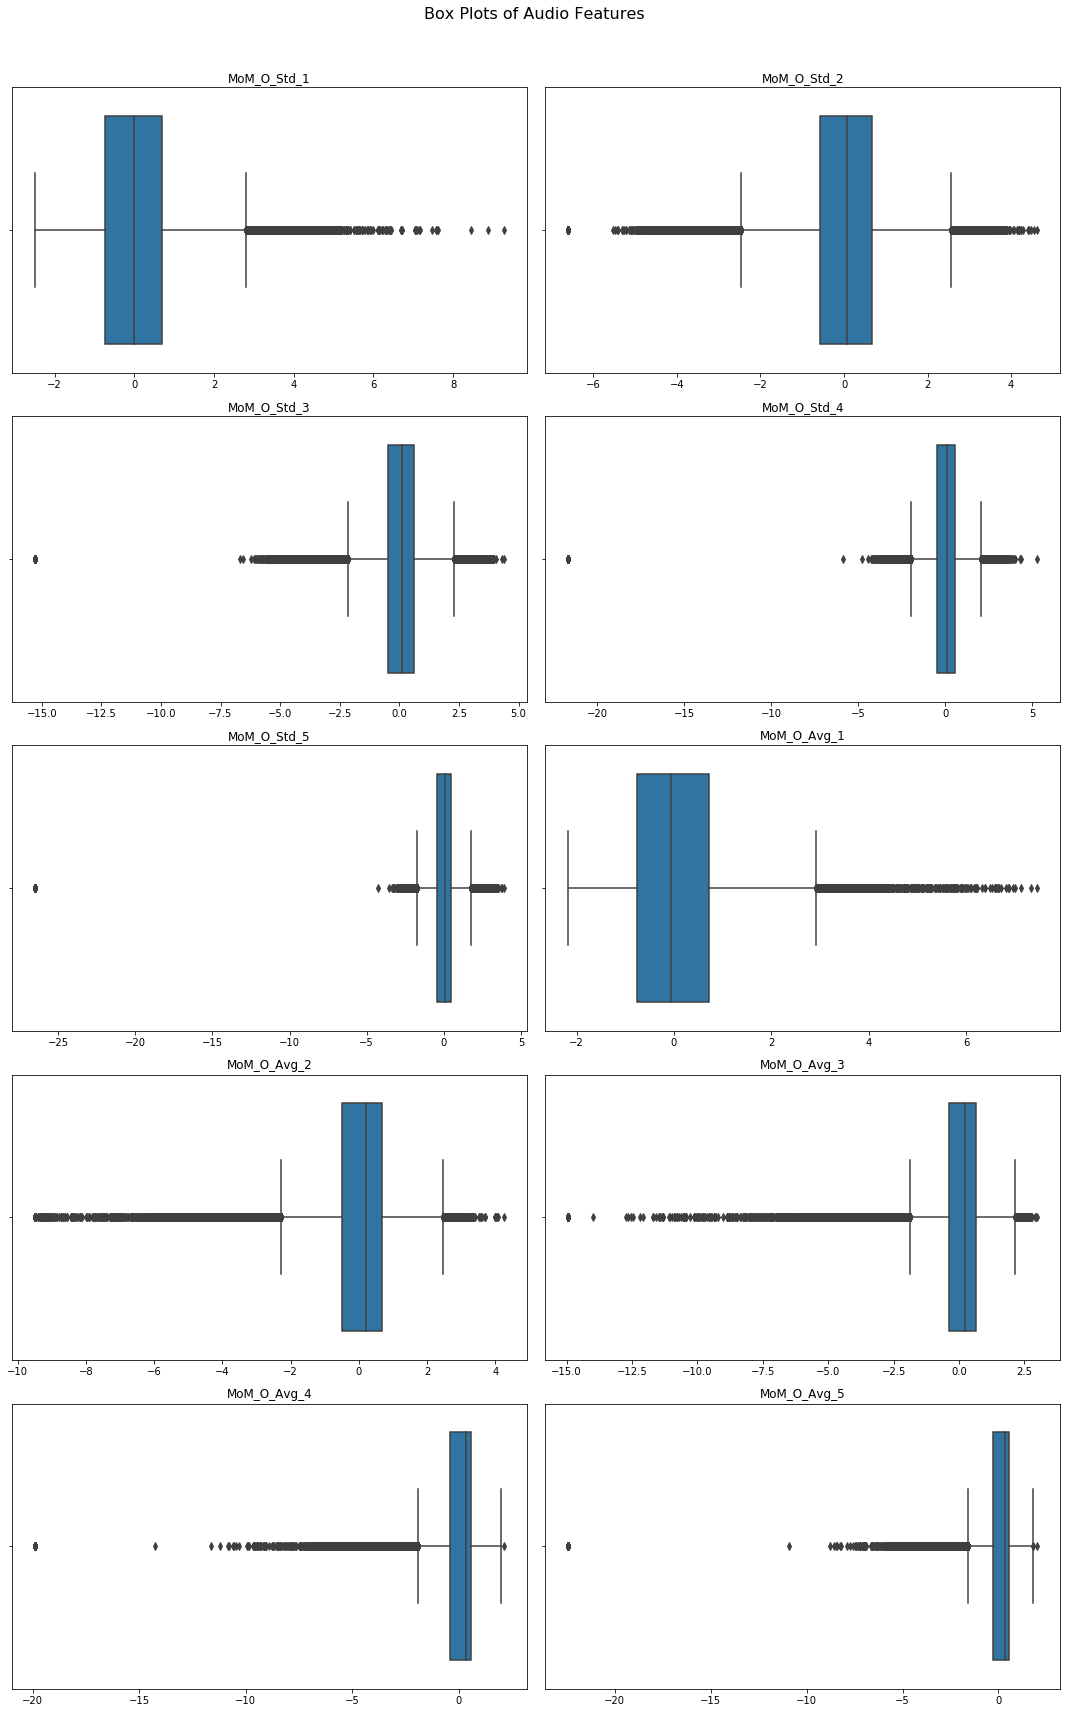

In [18]:
# Visualize the distribution of each audio feature
pandas_df = numeric_df.toPandas()

# Get the list of feature names
feature_names = numeric_df.columns

# Set up the plot
fig, axes = plt.subplots(nrows=(len(feature_names) + 1) // 2, ncols=2, figsize=(15, 5 * ((len(feature_names) + 1) // 2)))
fig.suptitle('Box Plots of Audio Features', fontsize=16)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Create a box plot for each feature
for i, feature in enumerate(feature_names):
    sns.boxplot(x=pandas_df[feature], ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('')

# Remove any unused subplots
for i in range(len(feature_names), len(axes)):
    fig.delaxes(axes[i])

# Adjust the layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

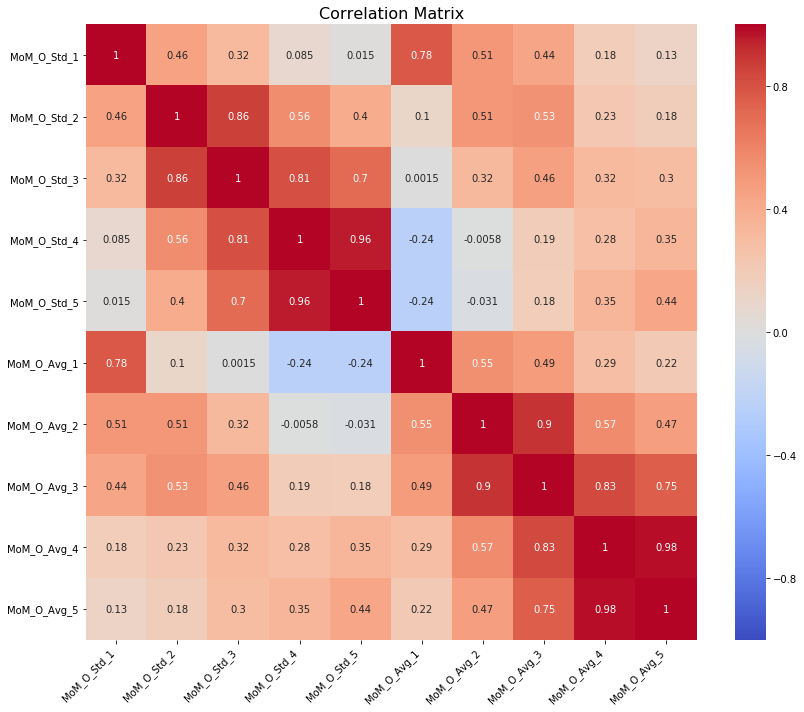

In [19]:
correlation_matrix = get_correlation_matrix(processed_df, feature_cols)
plot_correlation_heatmap(correlation_matrix)

In [18]:
# pick only one feature from the group with high correlation
# drop the column 'Method_of_Moments_Overall_Standard_Deviation_5' and 'Method_of_Moments_Overall_Average_5'
processed_df = processed_df.drop('MoM_O_Std_5', 'MoM_O_Avg_5')
show_as_html(processed_df)

,MoM_O_Std_1,MoM_O_Std_2,MoM_O_Std_3,MoM_O_Std_4,MoM_O_Avg_1,MoM_O_Avg_2,MoM_O_Avg_3,MoM_O_Avg_4,MSD_TRACKID
0,0.021394,0.764972,1.310185,0.485929,-0.109287,0.695421,-0.010428,-1.183623,TRHFHQZ12903C9E2D5
1,-0.517158,0.747169,0.530628,0.623284,-0.413553,0.418957,0.584733,0.592173,TRHFHYX12903CAF953
2,1.166516,-0.750198,-0.758610,-1.024949,2.546394,0.633674,0.009057,-0.830189,TRHFHAU128F9341A0E
3,1.105380,0.147083,-0.150877,-0.571255,0.502239,1.023316,0.817279,0.711048,TRHFHLP128F14947A7
4,0.464263,-0.322815,-0.777678,-0.824413,2.380547,0.932278,0.777553,0.779870,TRHFHFF128F930AC11
5,-0.107881,-0.410471,0.127522,0.546893,-0.342851,-0.855596,-0.557198,0.018809,TRHFHYJ128F4234782
6,-0.890525,-0.843525,-0.454572,-0.179982,-0.732032,-0.282703,-0.391362,-0.784730,TRHFHHR128F9339010
7,-1.032537,1.343297,0.314375,0.227092,-1.384948,-0.468392,-1.007493,-1.614065,TRHFHMB128F4213BC9
8,-0.827582,-0.526269,0.272324,0.761046,-0.534298,-1.682093,-1.018012,-0.356851,TRHFHWT128F429032D
9,1.257113,1.133780,0.962100,0.590750,0.369217,0.637945,0.815260,0.511223,TRHFHKO12903CBAF09


### (b)

In [19]:
magd_path = '/data/msd/genre/msd-MAGD-genreAssignment.tsv'
magd_df = spark.read.option("header", "false") \
               .option("delimiter", "\t") \
               .option("inferSchema", "true") \
               .csv(magd_path)
magd_df = magd_df.withColumnRenamed("_c0", "MSD_TRACKID").withColumnRenamed("_c1", "Genre")

magd_genre_count = magd_df.groupBy(F.col("Genre")).agg(F.count("*").alias("Count"))
show_as_html(magd_df)
show_as_html(magd_genre_count)
print(magd_genre_count.filter(F.col("Genre") == "Holiday").collect())

,MSD_TRACKID,Genre
0,TRAAAAK128F9318786,Pop_Rock
1,TRAAAAV128F421A322,Pop_Rock
2,TRAAAAW128F429D538,Rap
3,TRAAABD128F429CF47,Pop_Rock
4,TRAAACV128F423E09E,Pop_Rock
5,TRAAADT12903CCC339,Easy_Listening
6,TRAAAED128E0783FAB,Vocal
7,TRAAAEF128F4273421,Pop_Rock
8,TRAAAEM128F93347B9,Electronic
9,TRAAAFD128F92F423A,Pop_Rock


,Genre,Count
0,Stage,1614
1,Vocal,6195
2,Religious,8814
3,Easy_Listening,1545
4,Electronic,41075
5,Jazz,17836
6,International,14242
7,Blues,6836
8,Children,477
9,RnB,14335


[Row(Genre='Holiday', Count=200)]


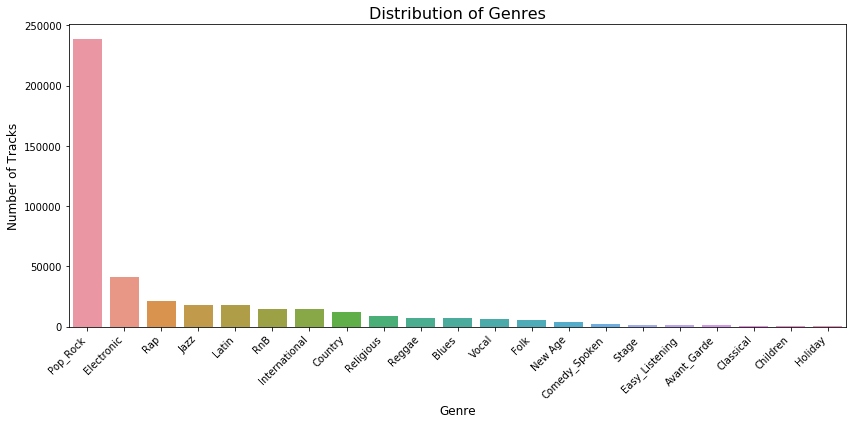

In [16]:
# Visualize the distribution of genres
# Collect the data from Spark DataFrame to a Pandas DataFrame
genre_counts_pd = magd_genre_count.toPandas()

# Sort the data by Count in descending order
genre_counts_pd = genre_counts_pd.sort_values('Count', ascending=False)

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Genre', y='Count', data=genre_counts_pd)

# Customize the plot
plt.title('Distribution of Genres', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Tracks', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

### (c)

In [20]:
# Merge the genres dataset and your audio features dataset
magd_feature_df = magd_df.join(
    processed_df,
    "MSD_TRACKID",
    "inner"
)

# Count the rows in the resulting DataFrame
row_count = magd_feature_df.count()

# Print the row count
print(f"Number of rows in magd_feature_df: {row_count}")

Number of rows in magd_feature_df: 420620


## Q2 Binary Classification

### (b)

In [45]:
# Transfer the genre column to a binary column, where 1 represents the "Electronic" genre
magd_electronic_df = magd_feature_df.withColumn(
    "Genre",
    F.when(F.col("Genre") == "Electronic", 1).otherwise(0)
)
show_as_html(magd_electronic_df)

,MSD_TRACKID,Genre,MoM_O_Std_1,MoM_O_Std_2,MoM_O_Std_3,MoM_O_Std_4,MoM_O_Avg_1,MoM_O_Avg_2,MoM_O_Avg_3,MoM_O_Avg_4
0,TRAAABD128F429CF47,0,-0.341464,-0.034254,-0.171638,-0.366827,-0.524161,-0.000779,-0.527973,-1.092760
1,TRAABPK128F424CFDB,0,-0.496855,-0.906450,-2.037903,-2.096709,0.787869,1.321030,0.932070,0.898939
2,TRAACER128F4290F96,0,1.878493,-0.194351,-0.339760,-0.035053,1.036407,0.231515,0.379544,0.604079
3,TRAADYB128F92D7E73,0,-0.282775,-0.704348,0.031946,0.348646,-0.309776,-1.377742,-0.812516,-0.178063
4,TRAAGHM128EF35CF8E,1,0.048648,0.061830,0.047646,-0.451768,0.245600,0.226595,0.623877,0.564373
5,TRAAGRV128F93526C0,0,-0.704109,-0.677726,-0.578778,-1.082284,0.450152,0.485430,0.620551,0.663264
6,TRAAGTO128F1497E3C,0,-0.715168,-0.196579,0.324011,0.585922,-1.454184,-0.354102,-0.048425,0.333454
7,TRAAHAU128F9313A3D,0,-1.067173,-0.184348,-0.247641,-0.655483,-0.459489,0.872308,0.784739,0.721296
8,TRAAHEG128E07861C3,0,0.253204,1.476221,1.002594,0.994520,-0.325425,0.284121,0.398165,0.366339
9,TRAAHZP12903CA25F4,0,0.185785,0.602577,0.334917,0.036001,-0.898733,1.083910,0.729693,0.705900


[Row(Genre=1, count=40666), Row(Genre=0, count=379954)]


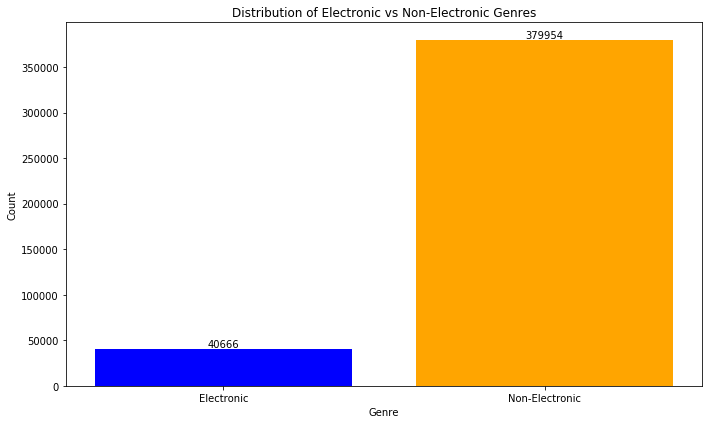

In [46]:
# Visualize the distribution of Electronic vs Non-Electronic genres
# Count the occurrences of 0s and 1s
genre_counts = magd_electronic_df.groupBy("Genre").count().collect()

print(genre_counts)

# Extract labels and values
labels = ['Electronic', 'Non-Electronic']
values = [row['count'] for row in genre_counts]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'orange'])

# Customize the plot
plt.title('Distribution of Electronic vs Non-Electronic Genres')
plt.xlabel('Genre')
plt.ylabel('Count')

# Add value labels on top of each bar
for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

### (c)

In [48]:
# Define the function of stratified split
def stratified_split(df, label_col, train_ratio=0.8, seed=42):
    # Calculate the fraction of each class
    class_fractions = df.groupBy(label_col).count().withColumn(
        "fraction", F.col("count") / df.count()
    )

    # Add a random number column
    df_with_random = df.withColumn("rand", F.rand(seed))

    # Add row numbers within each class
    window = Window.partitionBy(label_col).orderBy("rand")
    df_with_row_num = df_with_random.withColumn("row_num", F.row_number().over(window))

    # Join with class_fractions to get the count for each class
    df_with_count = df_with_row_num.join(class_fractions, on=label_col)

    # Calculate the split point for each class
    train_df = df_with_count.withColumn(
        "is_train",
        F.col("row_num") <= (F.col("count") * train_ratio)
    )

    # Split into train and test
    train = train_df.filter(F.col("is_train")).drop("rand", "row_num", "count", "fraction", "is_train")
    test = train_df.filter(~F.col("is_train")).drop("rand", "row_num", "count", "fraction", "is_train")

    return train, test

train_df, test_df = stratified_split(magd_electronic_df, label_col="Genre", train_ratio=0.8, seed=42)

In [22]:
# Define the function to print dataset information
def print_dataset_info(train_df: DataFrame, test_df: DataFrame, label_col: str = "Genre"):
    # Print row count for train_df and test_df
    print(f"Training set row count: {train_df.count()}")
    print(f"Testing set row count: {test_df.count()}")

    # Count the 0 and 1 samples for train_df
    train_counts = train_df.groupBy(label_col).count().collect()
    train_counts_dict = {row[label_col]: row['count'] for row in train_counts}
    print("Training set label counts:")
    for row in train_counts:
        print(f"Label {row[label_col]}: {row['count']}")

    # Calculate and print the ratio of label 1 and 0 in train_df
    train_label_0 = train_counts_dict.get(0, 0)
    train_label_1 = train_counts_dict.get(1, 0)
    train_ratio = train_label_1 / train_label_0 if train_label_0 != 0 else float('inf')
    print(f"Training set label 1 to 0 ratio: {train_ratio:.2f}")

    # Count the 0 and 1 samples for test_df
    test_counts = test_df.groupBy(label_col).count().collect()
    test_counts_dict = {row[label_col]: row['count'] for row in test_counts}
    print("Testing set label counts:")
    for row in test_counts:
        print(f"Label {row[label_col]}: {row['count']}")

    # Calculate and print the ratio of label 1 and 0 in test_df
    test_label_0 = test_counts_dict.get(0, 0)
    test_label_1 = test_counts_dict.get(1, 0)
    test_ratio = test_label_1 / test_label_0 if test_label_0 != 0 else float('inf')
    print(f"Testing set label 1 to 0 ratio: {test_ratio:.2f}")

print_dataset_info(train_df, test_df, label_col="Genre")

In [50]:
# Define the function to perform combined sampling
def combined_sampling(df, majority_label, minority_label, desired_ratio=0.7):
    majority_df = df.filter(F.col("Genre") == majority_label)
    minority_df = df.filter(F.col("Genre") == minority_label)
    
    total_count = df.count()
    majority_count = majority_df.count()
    minority_count = minority_df.count()
    
    # Calculate the desired counts
    desired_majority_count = int(total_count * desired_ratio)
    desired_minority_count = total_count - desired_majority_count
    
    # Calculate sampling ratios
    majority_sampling_ratio = desired_majority_count / majority_count
    minority_sampling_ratio = desired_minority_count / minority_count
    
    # Undersample majority class
    undersampled_majority = majority_df.sample(fraction=majority_sampling_ratio, withReplacement=False, seed=42)
    
    # Oversample minority class
    oversampled_minority = minority_df.sample(fraction=minority_sampling_ratio, withReplacement=True, seed=42)
    
    # Combine the resampled datasets
    resampled_df = undersampled_majority.unionAll(oversampled_minority)
    
    return resampled_df

# Assuming train_df is your training DataFrame from the previous split
majority_label = 0
minority_label = 1
desired_ratio = 0.7

resampled_train_df = combined_sampling(train_df, majority_label, minority_label, desired_ratio)

In [53]:
print_dataset_info(resampled_train_df, test_df, label_col="Genre")

Training set row count: 336531
Testing set row count: 84125
Training set label counts:
Label 1: 100852
Label 0: 235679
Training set label 1 to 0 ratio: 0.43
Testing set label counts:
Label 1: 8134
Label 0: 75991
Testing set label 1 to 0 ratio: 0.11


### (d, e, f)

In [57]:
# preprocess the resampled training and testing data for classification tasks
train_data = resampled_train_df.withColumn("label", F.col("Genre").cast(IntegerType()))
test_data = test_df.withColumn("label", F.col("Genre").cast(IntegerType()))

# Get the feature columns (all columns except 'genre' and 'MSD_TRACKID')
train_feature_columns = [col for col in resampled_train_df.columns if col not in ['Genre', 'MSD_TRACKID']]
test_feature_columns = [col for col in test_df.columns if col not in ['Genre', 'MSD_TRACKID']]

# Create a VectorAssembler to combine all features into a single vector column
train_vector_assembler = VectorAssembler(inputCols=train_feature_columns, outputCol="features")
test_vector_assembler = VectorAssembler(inputCols=test_feature_columns, outputCol="features")
train_data = train_vector_assembler.transform(train_data)
test_data = test_vector_assembler.transform(test_data)

In [24]:
# Define the evaluate function to print the evaluation metrics
def evaluate_binary_classification(pred):
    total = pred.count()
    
    nP_actual = pred.filter((F.col('label') == 1)).count()
    nN_actual = pred.filter((F.col('label') == 0)).count()
    
    nP = pred.filter((F.col('prediction') == 1)).count()
    nN = pred.filter((F.col('prediction') == 0)).count()
    TP = pred.filter((F.col('prediction') == 1) & (F.col('label') == 1)).count()
    FP = pred.filter((F.col('prediction') == 1) & (F.col('label') == 0)).count()
    FN = pred.filter((F.col('prediction') == 0) & (F.col('label') == 1)).count()
    TN = pred.filter((F.col('prediction') == 0) & (F.col('label') == 0)).count()
    
    accuracy = (TP + TN) / total
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='label', metricName='areaUnderROC')
    auroc = binary_evaluator.evaluate(pred)
    
    # Create a summary dictionary
    summary = {
        'Total Samples': total,
        'Actual Positive': nP_actual,
        'Actual Negative': nN_actual,
        'Predicted Positive': nP,
        'Predicted Negative': nN,
        'True Positive': TP,
        'False Positive': FP,
        'False Negative': FN,
        'True Negative': TN,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'AUC-ROC': auroc
    }
    
    # Print summary
    print("Classification Evaluation Summary:")
    print("==================================")
    for key, value in summary.items():
        print(f"{key:<20}: {value:.4f}" if isinstance(value, float) else f"{key:<20}: {value}")
    
    # Create confusion matrix plot
    cm = [[TN, FP], [FN, TP]]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return summary

Classification Evaluation Summary:
Total Samples       : 84125
Actual Positive     : 8134
Actual Negative     : 75991
Predicted Positive  : 50
Predicted Negative  : 84075
True Positive       : 13
False Positive      : 37
False Negative      : 8121
True Negative       : 75954
Accuracy            : 0.9030
Precision           : 0.2600
Recall              : 0.0016
F1 Score            : 0.0032
AUC-ROC             : 0.6829


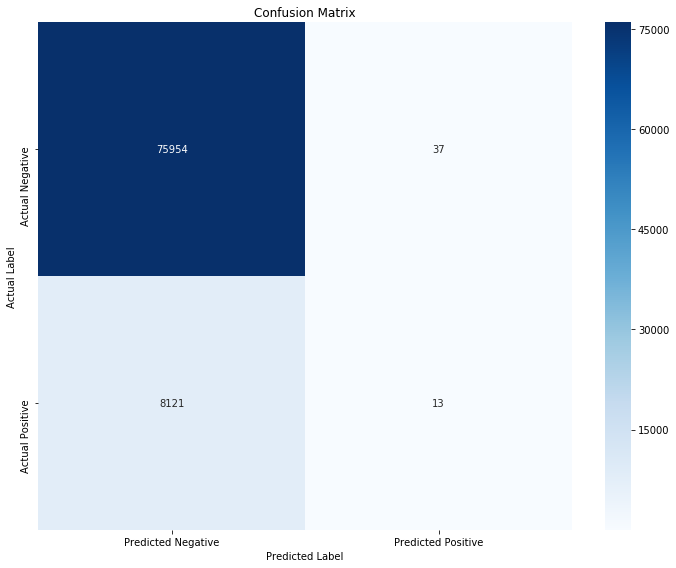

In [61]:
# Implement Logistic Regression
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0.0, featuresCol='features', labelCol='label')
lr_model = lr.fit(train_data)
# get the prediction on the test data
lr_pred = lr_model.transform(test_data)
lr_pred.cache()
# get the evaluation summary
evaluation_summary = evaluate_binary_classification(lr_pred)

Classification Evaluation Summary:
Total Samples       : 84125
Actual Positive     : 8134
Actual Negative     : 75991
Predicted Positive  : 7191
Predicted Negative  : 76934
True Positive       : 2655
False Positive      : 4536
False Negative      : 5479
True Negative       : 71455
Accuracy            : 0.8810
Precision           : 0.3692
Recall              : 0.3264
F1 Score            : 0.3465
AUC-ROC             : 0.7649


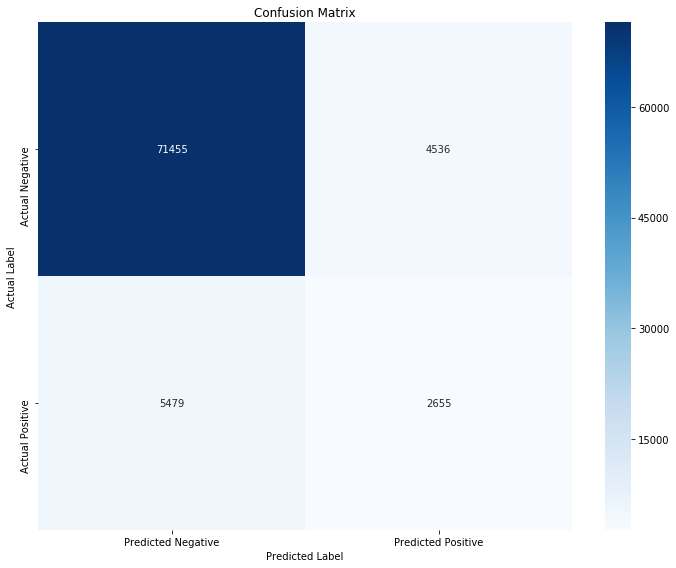

In [64]:
# Implement Random Forest
# Initialize the Random Forest Classifier
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='label',
    numTrees=100,  # Number of trees in the forest
    maxDepth=5,    # Maximum depth of each tree
    seed=42        # For reproducibility
)
# Fit the model on the training data
rf_model = rf.fit(train_data)
# Get the predictions on the test data
rf_pred = rf_model.transform(test_data)
rf_pred.cache()
# get the evaluation summary
evaluation_summary = evaluate_binary_classification(rf_pred)

Classification Evaluation Summary:
Total Samples       : 84125
Actual Positive     : 8134
Actual Negative     : 75991
Predicted Positive  : 10479
Predicted Negative  : 73646
True Positive       : 3465
False Positive      : 7014
False Negative      : 4669
True Negative       : 68977
Accuracy            : 0.8611
Precision           : 0.3307
Recall              : 0.4260
F1 Score            : 0.3723
AUC-ROC             : 0.7860


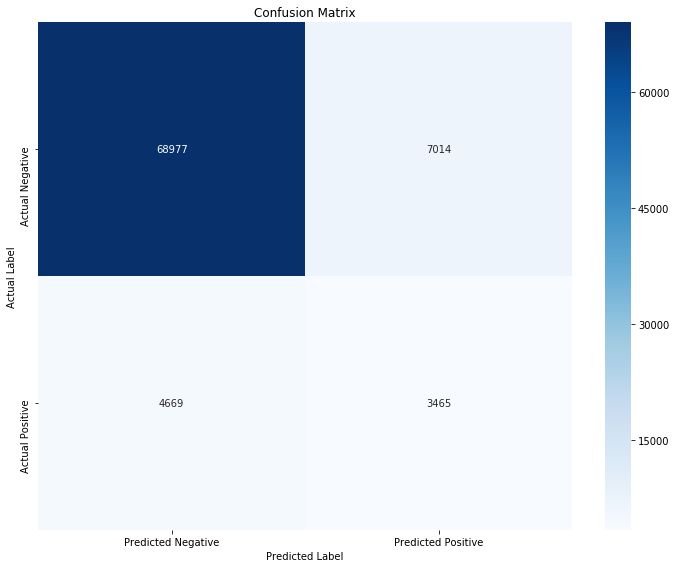

In [75]:
# Implement gradient boosted Tree model
# Initialize the Gradient Boosted Tree Classifier
gbt = GBTClassifier(
    featuresCol='features',
    labelCol='label',
    maxDepth=5,    # Maximum depth of the trees
    maxIter=10,    # Number of iterations (i.e., number of trees)
    stepSize=0.1,  # Learning rate
    subsamplingRate=1.0,  # Fraction of data used for training each tree
    seed=42        # For reproducibility
)
# Fit the model on the training data
gbt_model = gbt.fit(train_data)
# Make predictions on the test data
gbt_pred = gbt_model.transform(test_data)
gbt_pred.cache()
# get the evaluation summary
evaluation_summary = evaluate_binary_classification(gbt_pred)

## Q3 Multi-Class Classification

### (b)

In [25]:
# Create a StringIndexer
indexer = StringIndexer(inputCol="Genre", outputCol="label")

# Create a pipeline with the indexer
pipeline = Pipeline(stages=[indexer])

# Fit the pipeline to your data and transform
indexed_df = pipeline.fit(magd_feature_df).transform(magd_feature_df)

# The result will be in the 'label' column
# If you want to see the mapping between string labels and integers:
label_mapping = indexed_df.select("genre", "label").distinct().orderBy("label").show()

# If you want to drop the original 'genre' column:
final_df = indexed_df.drop("genre")

+--------------+-----+
|         genre|label|
+--------------+-----+
|      Pop_Rock|  0.0|
|    Electronic|  1.0|
|           Rap|  2.0|
|          Jazz|  3.0|
|         Latin|  4.0|
|           RnB|  5.0|
| International|  6.0|
|       Country|  7.0|
|     Religious|  8.0|
|        Reggae|  9.0|
|         Blues| 10.0|
|         Vocal| 11.0|
|          Folk| 12.0|
|       New Age| 13.0|
| Comedy_Spoken| 14.0|
|        Stage | 15.0|
|Easy_Listening| 16.0|
|   Avant_Garde| 17.0|
|     Classical| 18.0|
|      Children| 19.0|
+--------------+-----+
only showing top 20 rows



In [26]:
# count the number of each genre
final_genre_count = final_df.groupBy(F.col("label")).agg(F.count("*").alias("Count"))
show_as_html(final_genre_count)

,label,Count
0,6.0,14194
1,12.0,5789
2,13.0,4000
3,1.0,40666
4,10.0,6801
5,16.0,1535
6,19.0,463
7,5.0,14314
8,7.0,11691
9,4.0,17504


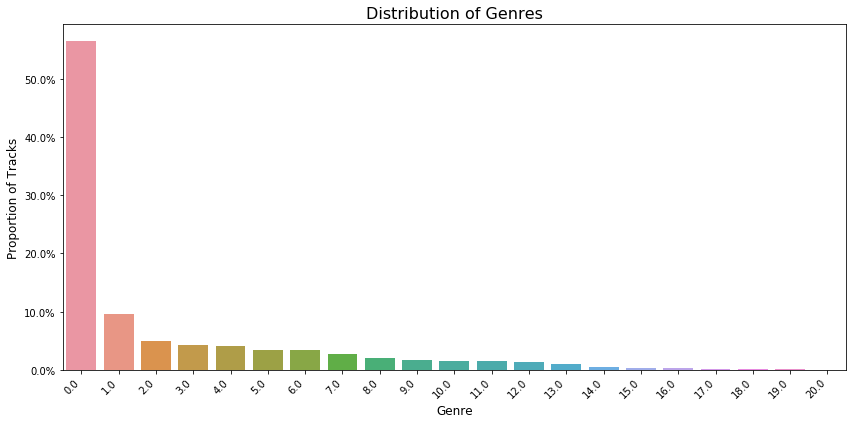

In [27]:
# Visualize the distribution of genres
# Collect the data from Spark DataFrame to a Pandas DataFrame
genre_counts_pd = final_genre_count.toPandas()

# Calculate the total number of tracks
total_tracks = genre_counts_pd['Count'].sum()

# Calculate the proportion for each genre
genre_counts_pd['Proportion'] = genre_counts_pd['Count'] / total_tracks

# Sort the data by Proportion in descending order
genre_counts_pd = genre_counts_pd.sort_values('Proportion', ascending=False)

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='label', y='Proportion', data=genre_counts_pd)

# Customize the plot
plt.title('Distribution of Genres', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Proportion of Tracks', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

### (c)

In [28]:
# Split the dataset into training and testing sets
train_df, test_df = stratified_split(final_df, label_col="label", train_ratio=0.8, seed=42)
print_dataset_info(train_df, test_df, label_col="label")

Training set row count: 336489
Testing set row count: 84131
Training set label counts:
Label 6.0: 11355
Label 12.0: 4631
Label 13.0: 3200
Label 1.0: 32532
Label 10.0: 5440
Label 16.0: 1228
Label 19.0: 370
Label 5.0: 11451
Label 7.0: 9352
Label 4.0: 14003
Label 17.0: 809
Label 20.0: 160
Label 8.0: 7024
Label 9.0: 5544
Label 14.0: 1653
Label 0.0: 190119
Label 18.0: 444
Label 3.0: 14220
Label 2.0: 16719
Label 11.0: 4945
Label 15.0: 1290
Training set label 1 to 0 ratio: 0.17
Testing set label counts:
Label 6.0: 2839
Label 12.0: 1158
Label 13.0: 800
Label 1.0: 8134
Label 10.0: 1361
Label 16.0: 307
Label 19.0: 93
Label 5.0: 2863
Label 7.0: 2339
Label 4.0: 3501
Label 17.0: 203
Label 20.0: 40
Label 8.0: 1756
Label 9.0: 1387
Label 14.0: 414
Label 0.0: 47530
Label 18.0: 111
Label 3.0: 3555
Label 2.0: 4180
Label 11.0: 1237
Label 15.0: 323
Testing set label 1 to 0 ratio: 0.17


In [31]:
# Use combined sampling to balance the training set
def balance_multiclass_v2(df: DataFrame, label_col: str) -> DataFrame:
    class_counts = df.groupBy(label_col).count().collect()
    num_classes = len(class_counts)
    
    # Calculate target sample size (can be average or median)
    target_count = sum(row['count'] for row in class_counts) // num_classes
    lower_bound = int(target_count * 0.7)
    upper_bound = int(target_count * 1.3)
    
    balanced_dfs = []
    
    for row in class_counts:
        class_label = row[label_col]
        class_count = row['count']
        class_df = df.filter(F.col(label_col) == class_label)
        
        if class_count < lower_bound:
            # Oversample to the lower bound
            oversampled = class_df.sample(withReplacement=True, fraction=lower_bound/class_count)
            balanced_dfs.append(oversampled.limit(lower_bound))
        elif class_count > upper_bound:
            # Undersample to the upper bound
            undersampled = class_df.sample(withReplacement=False, fraction=upper_bound/class_count)
            balanced_dfs.append(undersampled)
        else:
            # Keep as is
            balanced_dfs.append(class_df)
    
    # Use union method to merge all DataFrames
    balanced_df = balanced_dfs[0]
    for i in range(1, len(balanced_dfs)):
        balanced_df = balanced_df.union(balanced_dfs[i])
    
    return balanced_df

balanced_df = balance_multiclass_v2(train_df, 'label')
print_dataset_info(balanced_df, test_df, label_col="label")

Training set row count: 265868
Testing set row count: 84131
Training set label counts:
Label 6.0: 11355
Label 12.0: 11216
Label 13.0: 11216
Label 1.0: 20849
Label 10.0: 11216
Label 19.0: 11162
Label 16.0: 11216
Label 5.0: 11451
Label 7.0: 11216
Label 4.0: 14003
Label 17.0: 11125
Label 20.0: 11216
Label 8.0: 11173
Label 9.0: 11169
Label 14.0: 11216
Label 0.0: 20690
Label 18.0: 11082
Label 3.0: 14220
Label 2.0: 16719
Label 11.0: 11216
Label 15.0: 11142
Training set label 1 to 0 ratio: 1.01
Testing set label counts:
Label 6.0: 2839
Label 12.0: 1158
Label 13.0: 800
Label 1.0: 8134
Label 10.0: 1361
Label 16.0: 307
Label 19.0: 93
Label 5.0: 2863
Label 7.0: 2339
Label 4.0: 3501
Label 17.0: 203
Label 20.0: 40
Label 8.0: 1756
Label 9.0: 1387
Label 14.0: 414
Label 0.0: 47530
Label 18.0: 111
Label 3.0: 3555
Label 2.0: 4180
Label 11.0: 1237
Label 15.0: 323
Testing set label 1 to 0 ratio: 0.17


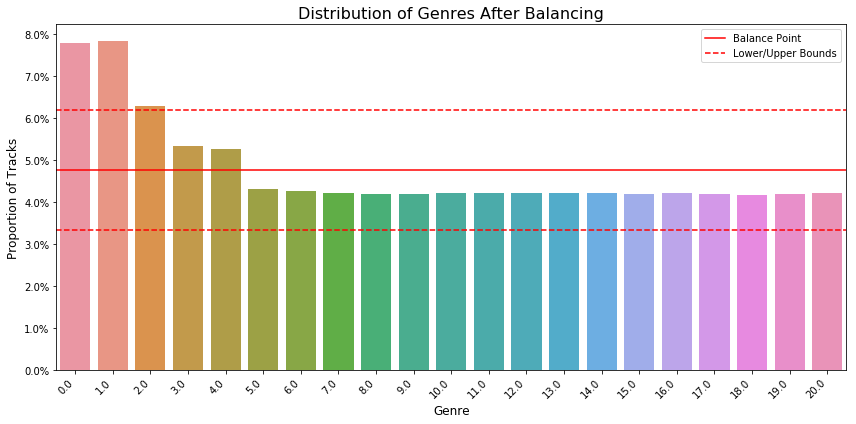

In [33]:
# Visualize the distribution of genres after balancing
balanced_genre_count = balanced_df.groupBy(F.col("label")).agg(F.count("*").alias("Count"))
# Collect the data from Spark DataFrame to a Pandas DataFrame
genre_counts_pd = balanced_genre_count.toPandas()

# Calculate the total number of tracks
total_tracks = genre_counts_pd['Count'].sum()

# Calculate the proportion for each genre
genre_counts_pd['Proportion'] = genre_counts_pd['Count'] / total_tracks

# Sort the data by Proportion in descending order
genre_counts_pd = genre_counts_pd.sort_values('Proportion', ascending=False)

# Calculate balance point and bounds
num_classes = len(genre_counts_pd)
balance_point = 1 / num_classes
lower_bound = balance_point * 0.7
upper_bound = balance_point * 1.3

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='label', y='Proportion', data=genre_counts_pd)

# Add balance point and bounds
plt.axhline(y=balance_point, color='r', linestyle='-', label='Balance Point')
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Lower/Upper Bounds')
plt.axhline(y=upper_bound, color='r', linestyle='--')

# Customize the plot
plt.title('Distribution of Genres After Balancing', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Proportion of Tracks', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Add legend
plt.legend()

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
# Get the feature columns (all columns except 'genre' and 'MSD_TRACKID')
train_feature_columns = [col for col in balanced_df.columns if col not in ['label', 'MSD_TRACKID']]
test_feature_columns = [col for col in test_df.columns if col not in ['label', 'MSD_TRACKID']]

# Create a VectorAssembler to combine all features into a single vector column
train_vector_assembler = VectorAssembler(inputCols=train_feature_columns, outputCol="features")
test_vector_assembler = VectorAssembler(inputCols=test_feature_columns, outputCol="features")
train_data = train_vector_assembler.transform(balanced_df)
test_data = test_vector_assembler.transform(test_df)

# drop the duplicate columns
train_data_processed = train_data \
    .select("label", "features") \
    .cache()

# drop the duplicate columns
test_data_processed = test_data \
    .select("label", "features") \
    .cache()

# force the data to be cached
train_data_processed.count()
test_data_processed.count()

84131

In [39]:
# create a Random Forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)

# train the model
model = rf.fit(train_data_processed)

# get the prediction on the test data
multi_rf_pred = model.transform(test_data)

In [58]:
# get the evaluation summary
print("Overall Model Performance:")
print("--------------------------")

# Calculate overall accuracy
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_accuracy.evaluate(multi_rf_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate weighted F1-score
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedFMeasure")
f1_score = evaluator_f1.evaluate(multi_rf_pred)
print(f"Weighted F1-score: {f1_score:.4f}")

# Calculate weighted precision
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(multi_rf_pred)
print(f"Weighted Precision: {precision:.4f}")

# Calculate weighted recall
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(multi_rf_pred)
print(f"Weighted Recall: {recall:.4f}")

# Feature importance
feature_importance = model.featureImportances
print("\nFeature Importance:")
print(f"{feature_importance}")

# Detailed evaluation using MulticlassMetrics
preds_and_labels = multi_rf_pred.select(['prediction','label']).rdd.map(lambda row: (float(row['prediction']), float(row['label'])))
metrics = MulticlassMetrics(preds_and_labels)

# Get unique labels
labels = multi_rf_pred.select("label").distinct().rdd.map(lambda r: r[0]).collect()

# Initialize lists to store data
genres = []
precision = []
recall = []
f1_score = []

# Confusion Matrix
conf_matrix = metrics.confusionMatrix().toArray()
print("\nConfusion Matrix:")
print(conf_matrix)

Overall Model Performance:
--------------------------
Accuracy: 0.3905
Weighted F1-score: 0.4182
Weighted Precision: 0.4862
Weighted Recall: 0.3905

Feature Importance:
(8,[0,1,2,3,4,5,6,7],[0.21187558072332766,0.24433670574545321,0.08881835115111995,0.06662035196942961,0.1760278440331062,0.0834506140312701,0.05603328711923077,0.07283726522706264])

Confusion Matrix:
[[2.6504e+04 3.7790e+03 5.5040e+03 6.4600e+02 6.2000e+02 3.0000e+01
  0.0000e+00 7.1500e+02 0.0000e+00 3.5000e+02 3.0600e+02 1.8080e+03
  0.0000e+00 4.3100e+02 1.8120e+03 6.1000e+02 1.0700e+03 4.4800e+02
  2.4100e+02 1.5500e+02 2.5010e+03]
 [1.6430e+03 2.3510e+03 2.3160e+03 1.7500e+02 1.9000e+01 2.0000e+00
  0.0000e+00 3.5000e+01 0.0000e+00 1.0900e+02 4.2000e+01 1.5200e+02
  0.0000e+00 1.5200e+02 3.4800e+02 1.4400e+02 1.5000e+02 1.4700e+02
  6.8000e+01 3.1000e+01 2.5000e+02]
 [3.7700e+02 5.8500e+02 2.6010e+03 3.0000e+01 2.3000e+01 0.0000e+00
  0.0000e+00 2.2000e+01 0.0000e+00 8.4000e+01 9.0000e+00 5.2000e+01
  0.0000e+00 5

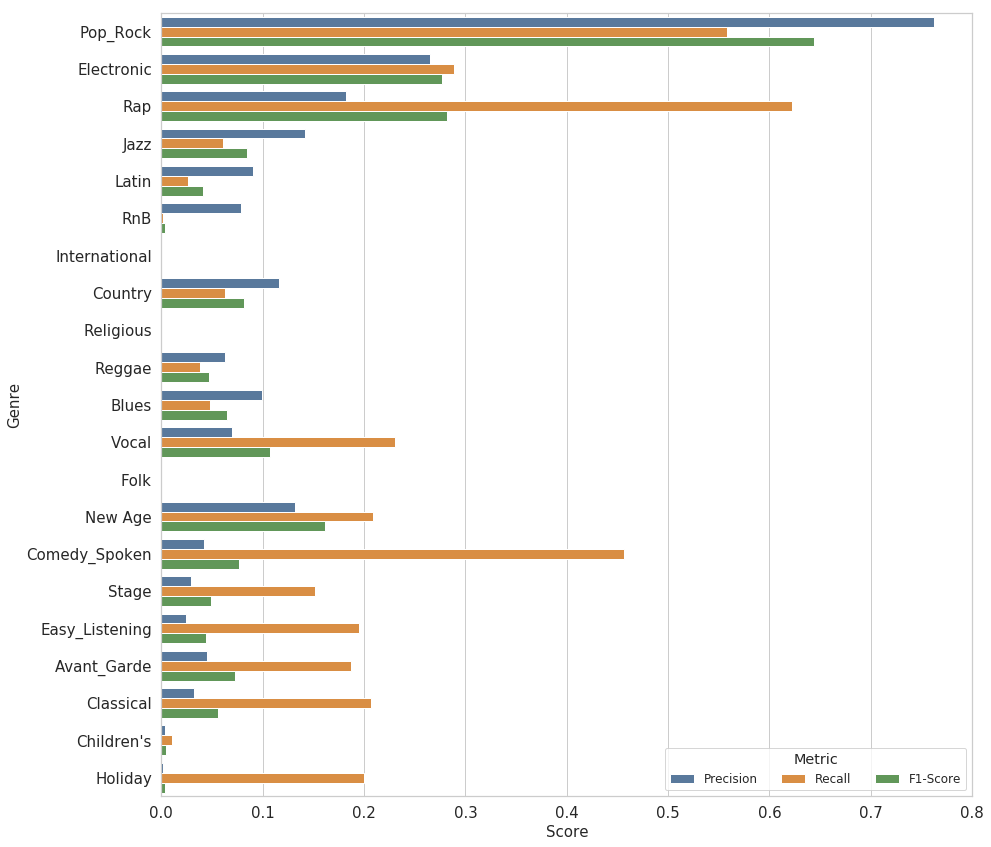

In [68]:
# get each class precision, recall, and f1-score
# Get unique labels
labels = multi_rf_pred.select("label").distinct().rdd.map(lambda r: r[0]).collect()

# Define the real genre labels
genre_labels = ['Pop_Rock', 'Electronic', 'Rap', 'Jazz', 'Latin', 'RnB', 'International', 'Country', 'Religious', 'Reggae', 
                'Blues', 'Vocal', 'Folk', 'New Age', 'Comedy_Spoken', 'Stage', 'Easy_Listening', 'Avant_Garde', 'Classical', 
                "Children's", 'Holiday']

# Initialize lists to store data
genres = []
precision = []
recall = []
f1_score = []

# Collect data from the for loop (simulated here)
for i, label in enumerate(sorted(labels)):
    genres.append(genre_labels[i])  # Use real genre labels instead of class numbers
    precision.append(metrics.precision(label))
    recall.append(metrics.recall(label))
    f1_score.append(metrics.fMeasure(label, beta=1.0))

# Create a DataFrame for easier plotting with Seaborn
df = pd.DataFrame({
    'Genre': genres,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score
})

# Melt the DataFrame to long format
df_melted = pd.melt(df, id_vars=['Genre'], var_name='Metric', value_name='Score')

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))  # Increased figure size for better readability

# Set a more aesthetically pleasing color palette
colors = ["#4e79a7", "#f28e2b", "#59a14f"]

# Create the Seaborn plot
sns.set(style="whitegrid", font_scale=1.2)  # Increase overall font scale
ax = sns.barplot(x='Score', y='Genre', hue='Metric', data=df_melted, palette=colors)

# Customize the plot
plt.xlabel('Score', fontsize=15)
plt.ylabel('Genre', fontsize=15)

# Increase font size of axis labels
ax.tick_params(axis='both', labelsize=15)

# Move legend to bottom right inside the plot area and increase font size
ax.legend(title='Metric', loc='lower right', bbox_to_anchor=(1, 0), ncol=3, fontsize=12)

# Adjust layout and show
plt.tight_layout()
plt.show()

In [69]:
stop_spark()